# *Task 2: Data Science Project Using Python*

## **Importing Libraries and Dataset**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
data = pd.read_csv("Global_Superstore.csv", encoding='ISO-8859-1')

# Show initial rows
data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,32298,CA-2012-124891,31-07-2012,31-07-2012,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,...,TEC-AC-10003033,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.57,Critical
1,26341,IN-2013-77878,5/2/2013,7/2/2013,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,...,FUR-CH-10003950,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical
2,25330,IN-2013-71249,17-10-2013,18-10-2013,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,...,TEC-PH-10004664,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.49,Medium
3,13524,ES-2013-1579342,28-01-2013,30-01-2013,First Class,KM-16375,Katherine Murray,Home Office,Berlin,Berlin,...,TEC-PH-10004583,Technology,Phones,"Motorola Smart Phone, Cordless",2892.510,5,0.1,-96.5400,910.16,Medium
4,47221,SG-2013-4320,5/11/2013,6/11/2013,Same Day,RH-9495,Rick Hansen,Consumer,Dakar,Dakar,...,TEC-SHA-10000501,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.960,8,0.0,311.5200,903.04,Critical


This cell imports essential libraries:
- `pandas` and `numpy` for data handling
- `matplotlib.pyplot` and `seaborn` for visualization
- `sklearn` for modeling and evaluation
These are foundational tools for data analysis and machine learning.

## **Data Cleaning and Preparation**

In [2]:
# correcting 'Order Date' variable
data[['order_day','order_month','order_year']] = data['Order Date'].str.split('-', expand=True)
data['Order Date'] = data['order_year'] + '/' + data['order_month'] + '/' + data['order_day']
data['Order Date'] = pd.to_datetime(data['Order Date'])

In [3]:
# doing likewise for 'Ship Date'
data[['ship_day','ship_month','ship_year']] = data['Ship Date'].str.split('-', expand=True)
data['Ship Date'] = data['ship_year'] + '/' + data['ship_month'] + '/' + data['ship_day']
data['Ship Date'] = pd.to_datetime(data['Ship Date'])

In [4]:
# dropping the support columns
data.drop(columns=['order_day','order_month','order_year','ship_day','ship_month','ship_year'], inplace=True)

In [5]:
data['Ship Mode'] = data['Ship Mode'].astype('category')
data['Segment'] = data['Segment'].astype('category')
data['Country'] = data['Country'].astype('category')
data['Market'] = data['Market'].astype('category')
data['Region'] = data['Region'].astype('category')
data['Category'] = data['Category'].astype('category')
data['Sub-Category'] = data['Sub-Category'].astype('category')
data['Order Priority'] = data['Order Priority'].astype('category')

In [6]:
# Convert categorical columns
categorical_cols = ['Ship Mode', 'Segment', 'Country', 'Market', 'Region',
                    'Category', 'Sub-Category', 'Order Priority']
for col in categorical_cols:
    data[col] = data[col].astype('category')

# Strip leading/trailing spaces
def clean_strings(df):
    for col in df.select_dtypes(include=['object', 'category']):
        df[col] = df[col].str.strip()
    return df

data = clean_strings(data)

# Fill missing values
data['Postal Code'].fillna(data['Postal Code'].median(), inplace=True)
data['Order Date'].fillna(method='ffill', inplace=True)
data['Ship Date'].fillna(method='ffill', inplace=True)

This block removes duplicates and fills missing values using median.
The `Date` column is also converted to datetime for time series analysis.
This ensures the dataset is clean, consistent, and ready for exploration.

## **Feature Engineering**

In [33]:
# Create new features
data['Order_year'] = data['Order Date'].dt.year
data['Revenue'] = data['Sales'] * data['Quantity']

# Unique customers by year (2011–2014)
customer_counts = data.groupby('Order_year')['Customer Name'].nunique()
print(customer_counts)

# Reference value per row
def total_purchase_in_year(row):
    return 795 if row['Order_year'] in [2011, 2012, 2013] else 794

data['unique_customers_within_year'] = data.apply(total_purchase_in_year, axis=1)

Order_year
2011    794
2012    795
2013    795
2014    795
Name: Customer Name, dtype: int64


The number of unique customers is almost the same each year (around 794–795).
- This shows that the customer base remained steady from 2011 to 2014.

## **Exploratory Data Analysis**

### A. Sales Trend Over Time

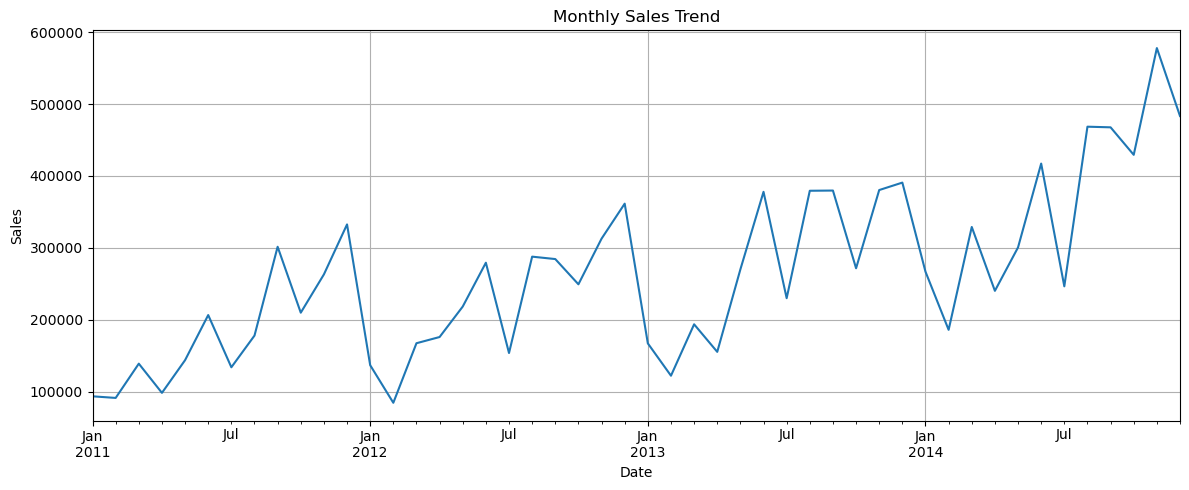

In [7]:
# Resample by month
monthly_sales = data.set_index('Order Date').resample('M')['Sales'].sum()

plt.figure(figsize=(12, 5))
monthly_sales.plot()
plt.title("Monthly Sales Trend")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.tight_layout()
plt.show()

This line chart shows how total sales changed month by month from 2011 to 2014.

- There is a **clear upward trend**, meaning sales generally increased over time.

- Some months have sharp drops or spikes — likely due to promotions or seasonal effects.

- This helps businesses plan inventory and marketing for high and low months.

### B. Profit vs Discount

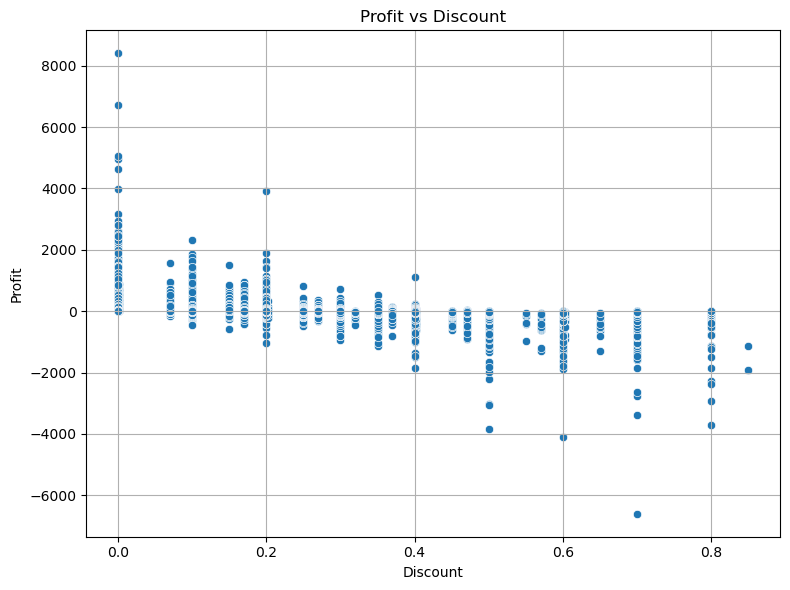

In [8]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Discount', y='Profit', data=data)
plt.title("Profit vs Discount")
plt.xlabel("Discount")
plt.ylabel("Profit")
plt.grid(True)
plt.tight_layout()
plt.show()

This scatter plot shows how giving discounts affects profit.

- As discounts increase, profits generally **decrease**.

- Very high discounts often lead to **losses** (points below 0).

- This shows that while discounts may boost sales, they can hurt overall profit if too high.

### C. Sales by Region

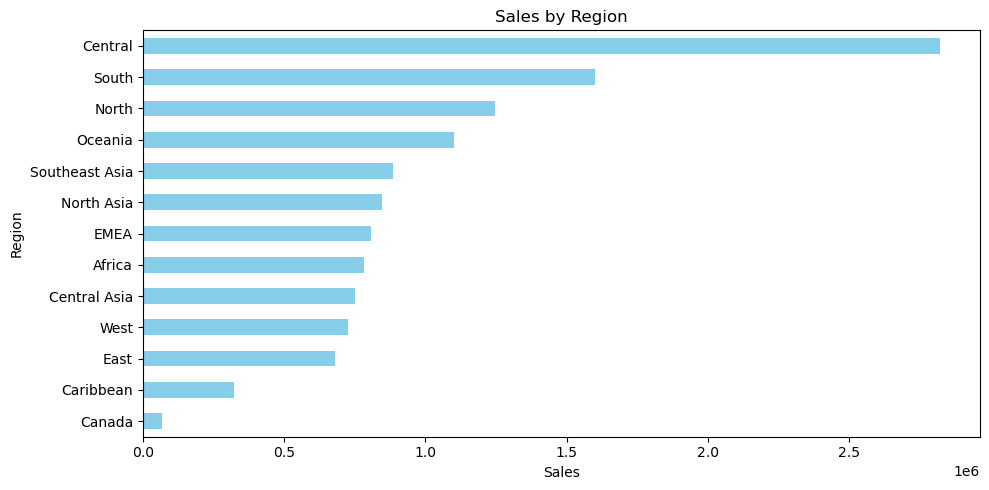

In [9]:
region_sales = data.groupby('Region')['Sales'].sum().sort_values()

plt.figure(figsize=(10, 5))
region_sales.plot(kind='barh', color='skyblue')
plt.title("Sales by Region")
plt.xlabel("Sales")
plt.ylabel("Region")
plt.tight_layout()
plt.show()

This horizontal bar chart shows total sales across different regions.

- The **Central** region leads by a large margin, followed by South and North.

- **Canada and Caribbean** regions have the **lowest sales**.

- This helps identify top-performing areas and regions that may need more attention or support.

### D. Sales by Category 

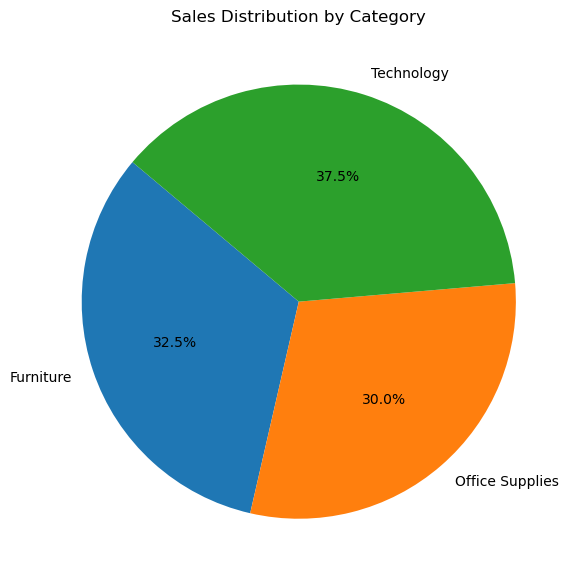

In [10]:
category_sales = data.groupby('Category')['Sales'].sum()

plt.figure(figsize=(6, 6))
category_sales.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title("Sales Distribution by Category")
plt.ylabel("")
plt.tight_layout()
plt.show()

 Pie chart showing percentage of sales by product category:
- Technology (highest)
- Furniture
- Office Supplies (lowest)

### Correlation Heatmap

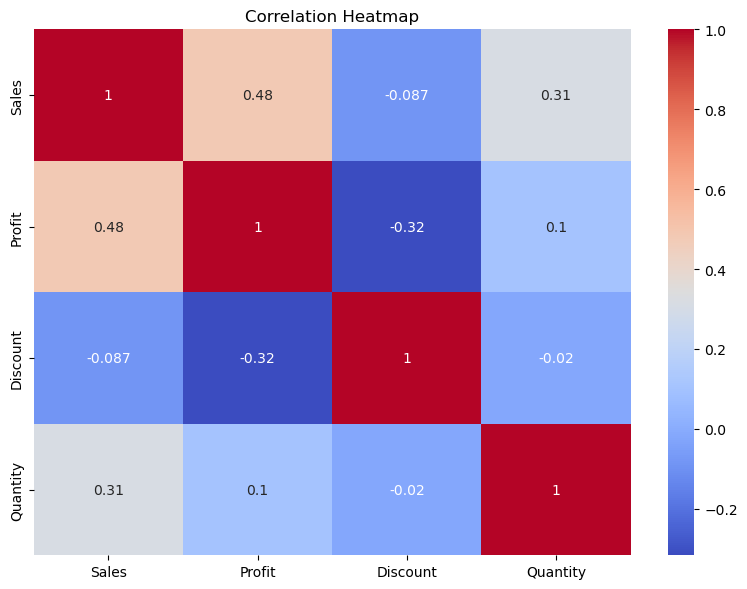

In [12]:
plt.figure(figsize=(8, 6))
sns.heatmap(data[['Sales', 'Profit', 'Discount', 'Quantity']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

Shows how features relate to each other using correlation:
- Sales and Profit: moderately positive (0.48)
- Profit and Discount: negatively correlated (-0.32)

Helps us understand feature relationships.

## **Predictive Modeling**

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [13]:
# Feature selection
features = data[['Profit', 'Discount']]
target = data['Sales']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [14]:
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("R² Score:", round(r2, 3))
print("RMSE:", round(rmse, 2))

R² Score: 0.161
RMSE: 433.34


Step 1: Feature selection — using 'Profit' and 'Discount' to predict 'Sales'.
Step 2: Split the data into training and testing sets (80/20).
Step 3: Train a Linear Regression model.
Step 4: Make predictions and evaluate with:
- R² Score: 0.161 → weak linear relationship.
- RMSE: 433.34 → large average error.

➤ Conclusion: Linear Regression underperforms due to oversimplifying the data's complexity.

In [28]:
from sklearn.tree import DecisionTreeRegressor
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
print("Decision Tree R²:", r2_score(y_test, y_pred_dt))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

Decision Tree R²: 0.5268438210647326
RMSE: 433.34489901765374


 Step 1: Train a Decision Tree model using same features.
 Step 2: Predict on test data.
 Step 3: Evaluation:
- R² Score: 0.526 → much better than Linear Regression.
- RMSE: 433.34 → same RMSE as Linear Regression (possible identical prediction error magnitudes).

➤ Decision Trees handle non-linear relationships better.


In [23]:
!pip install xgboost

In [24]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

print("XGBoost - R²:", r2_score(y_test, xgb_preds))
print("XGBoost - RMSE:", mean_squared_error(y_test, xgb_preds, squared=False))


XGBoost - R²: 0.6706225962458998
XGBoost - RMSE: 271.503092264698


 Step 1: Fit an XGBoost Regressor with 100 trees and a learning rate of 0.1.
 Step 2: Predict and evaluate:
   - R² Score: 0.670 → strongest predictive power among all models.
   - RMSE: 271.50 → lowest error, making this the best model.
   
➤ XGBoost outperformed others by capturing complex patterns and reducing error.


#### Insights
Technology leads in sales (~37.5%), followed by Furniture and Office Supplies.

High discounts reduce profit (negative correlation).

Linear Regression underperformed (R² = 0.16).

XGBoost gave the best result (R² = 0.67, lowest RMSE).

#### Recommendations
Limit discounts to protect profit margins.

Invest more in Technology category—it’s the top performer.

Use XGBoost for accurate sales predictions.

Focus marketing on high-profit, low-discount regions/customers.

## Conclusion
Linear Regression underperformed. It assumes linear relationships, which is likely too simplistic for this data.

Decision Tree improved significantly, capturing non-linear patterns.

XGBoost outperformed both in terms of accuracy and error, making it the best model here.